# Косенко Никита
## Лабораторная работа №2, вариант 9

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.metrics import average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

Подключаем данные

In [180]:
data = pd.read_csv('data_ml_v2-09.csv')
X = data[['x1', 'x2']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
data

,x1,x2,label
0,2.09900,1.18550,1
1,4.08970,2.34480,1
2,2.29870,1.53440,1
3,2.31340,0.83835,1
4,2.77860,0.52184,1
...,...,...,...
495,0.74488,4.03800,4
496,0.97697,3.33700,4
497,-0.38525,5.38230,4
498,1.28370,2.65840,4


### Задание 1
Оценить ковариационные матрицы обучающих данных для каждого класса при различных предположениях:

a) ковариационные матрицы всех классов равные, скалярные

б) равные, диагональные

в) различные, скалярные

г) различные, диагональные

д) равные

е) различные

Визуализировать матрицы для каждого случая.

In [181]:
# Получаем уникальные классы
classes = np.sort(y_train.unique())
print(classes)

# Инициализируем словарь для хранения ковариационных матриц
cov_matrices = {}

[1 2 3 4]


In [182]:
# a) ковариационные матрицы всех классов равные, скалярные
var1 = np.var(X_train, axis=0)['x1']
var2 = np.var(X_train, axis=0)['x2']
var = (var1 + var2) / 2
cov_equal_scalar = np.array([[var, 0], [0, var]])
# print(cov)
# print(var)
# cov_equal_scalar = np.cov(X_train.T) * np.eye(X_train.shape[1])
cov_matrices['equal, scalar'] = cov_equal_scalar
# print(cov_matrices["equal, scalar"])

In [183]:
# б) равные, диагональные
cov_equal_diagonal = np.cov(X_train.T) * np.eye(X_train.shape[1])# np.diag(np.var(X_train, axis=0))
cov_matrices['equal, diagonal'] = cov_equal_diagonal
# print(cov_matrices["equal, diagonal"])

In [184]:
# в) различные, скалярные
for cls in classes:
    var1 = np.var(X_train[y_train == cls], axis=0)['x1']
    var2 = np.var(X_train[y_train == cls], axis=0)['x2']
    var = (var1 + var2) / 2
    cov_matrices[f'different, scalar, class {cls}'] = np.array([[var, 0], [0, var]])

In [185]:
# г) различные, диагональные
for cls in classes:
    cov_matrices[f'different, diagonal, class {cls}'] = np.cov(X_train[y_train == cls].T) * np.eye(X_train.shape[1]) # np.diag(
        # np.var(X_train[y_train == cls], axis=0))
    # print(cov_matrices[f'different, diagonal, class {cls}'])
    # print()

In [207]:
# д) равные
cov_equal = np.cov(X_train.T)
cov_matrices['equal'] = cov_equal
# print(cov_matrices['equal'])

In [187]:
# е) различные
for cls in classes:
    cov_matrices[f'different, class {cls}'] = np.cov(X_train[y_train == cls].T)
    # print(cov_matrices[f'different, class {cls}'])
    # print()

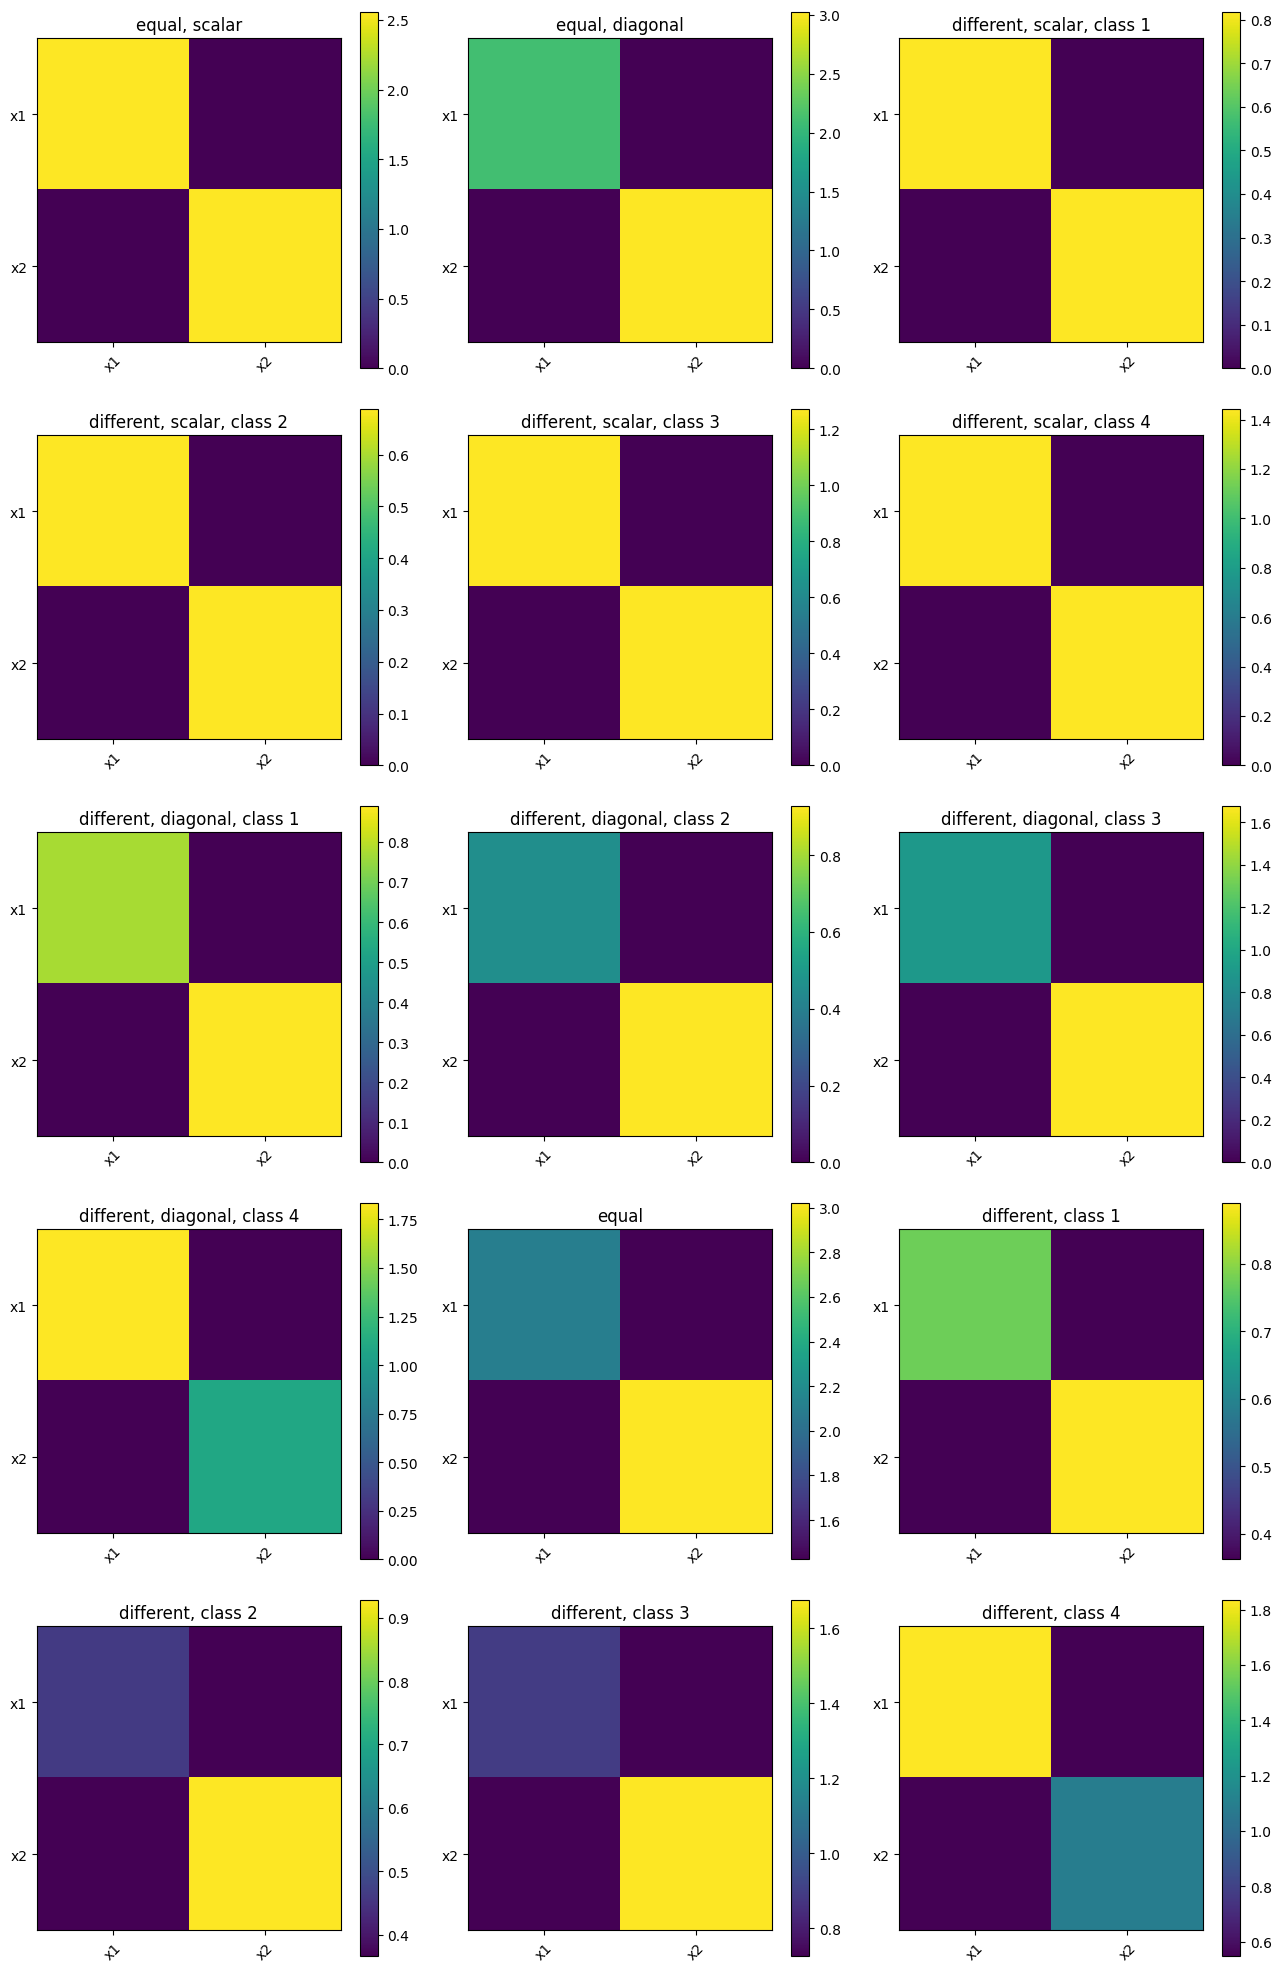

In [188]:
# Визуализация ковариационных матриц
num_matrices = len(cov_matrices)

plt.figure(figsize=(13, 4 * 5))
for i, (key, cov_matrix) in enumerate(cov_matrices.items()):
    plt.subplot(5, 3, i + 1)
    plt.imshow(cov_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(key)
    plt.xticks(range(cov_matrix.shape[0]), ['x1', 'x2'], rotation=45)
    plt.yticks(range(cov_matrix.shape[0]), ['x1', 'x2'])

plt.tight_layout()
plt.show()

### Задание 2
Рассчитать классификационные очки байесовских классификаторов, обученных при предположениях а-е пункта 1 для примеров обучающей и тестовой выборок. Априорные вероятности классов считать равными, классификационные очки классификаторов полагать равными апостериорным вероятностям классов.

Реализуем классификатор. Поскольку классов 4, а априорные вероятности считаем равными,то для каждого класса априорная вероятность равна 1/4.
Поскольку классификатор байессовский, теорема Байеса применима:
$$
P(C_k | \mathbf{x}) = \frac{P(\mathbf{x} | C_k) P(C_k)}{P(\mathbf{x})}
$$

Где:
- $ P(C_k | \mathbf{x}) $ — апостериорная вероятность класса $ C_k $ при условии наблюдения $ \mathbf{x} $.
- $ P(\mathbf{x} | C_k) $ — правдоподобие (likelihood) наблюдения $ \mathbf{x} $ при условии класса $ C_k $.
- $ P(C_k) $ — априорная вероятность класса $ C_k $.
- $ P(\mathbf{x}) $ — нормализующая константа, которая может быть вычислена как сумма по всем классам.

#### Нормальный Байесовский Классификатор
Формула для правдоподобия $ P(\mathbf{x} | C_k) $ в нормальном классификаторе выглядит следующим образом:

$$
P(\mathbf{x} | C_k) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu_k)^T \Sigma_k^{-1} (\mathbf{x} - \mu_k)\right)
$$

Где:
- $ d $ — количество признаков (размерность).
- $ \mu_k $ — вектор средних значений признаков для класса $ C_k $.
- $ \Sigma_k $ — ковариационная матрица для класса $ C_k $.
- $ | \Sigma_k | $ — определитель ковариационной матрицы.
- $ \Sigma_{k}^{-1} $ — обратная ковариационная матрица.

---

#### Общая Формула для Классификации

Для классификации, мы выбираем класс $ C_k $, который максимизирует апостериорную вероятность:

$$
\hat{C} = \arg\max_{C_k} P(C_k | \mathbf{x}) = \arg\max_{C_k} P(\mathbf{x} | C_k) P(C_k)
$$

In [189]:
class NormalBayesClassifier:
    def __init__(self, covariances: dict):
        self.means = {}
        self.priors = {}
        self.classes = None
        self.covariances = covariances

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.means[cls] = X_cls.mean(axis=0)
            self.priors[cls] = 0.25

    def predict_all(self, X):  # predict all the observations
        predicts = []
        classes = []
        for x in zip(X['x1'], X['x2']):
            p, c = self.predict(x)
            predicts.append(p)
            classes.append(c)
        return predicts, classes

    def predict(self, x):  # predict the class and posteriors of one observation
        posteriors = []
        en = {}
        if len(self.covariances) == 1:
            en[1] = list(self.covariances.values())[0]
            en[2] = list(self.covariances.values())[0]
            en[3] = list(self.covariances.values())[0]
            en[4] = list(self.covariances.values())[0]
        else:
            en[1] = list(self.covariances.values())[0]
            en[2] = list(self.covariances.values())[1]
            en[3] = list(self.covariances.values())[2]
            en[4] = list(self.covariances.values())[3]
        for cls in self.classes:
            prior = self.priors[cls]
            likelihood = self._multivariate_gaussian(
                x, self.means[cls], en[cls])
            posterior = prior * likelihood
            posteriors.append(posterior)

        return posteriors, self.classes[np.argmax(posteriors, axis=0)]

    def _multivariate_gaussian(self, x, mean, cov):
        d = 2  # number of features
        cov_inv = np.linalg.inv(cov)  # dimention is 2 × 2
        norm_const = 1 / (2 * np.pi)**(d/2) * np.sqrt(np.linalg.det(cov))
        centered = x - mean  # dimention is 2 × 1
        # for transposed centered dimention is 1 × 2
        i = np.dot(centered.T, cov_inv)
        p = np.exp(-0.5 * np.dot(i, centered))
        return norm_const * p

Получение классификационных очков

In [190]:
classifiers = {}

# Обрабатываем каждый ключ в словаре
for key, covariance_matrix in cov_matrices.items():
    # Проверяем, содержит ли ключ информацию о классе
    if 'equal' in key:
        # print(key)
        # print(covariance_matrix)
        classifiers[key] = NormalBayesClassifier({key: covariance_matrix})

In [191]:
different_scalar_matrices = {}
for key, covariance_matrix in cov_matrices.items():
    if 'different, scalar' in key:
        different_scalar_matrices[key] = covariance_matrix

# for key, covariance_matrix in different_scalar_matrices.items():
#     print(key)
#     print(covariance_matrix)
#     print()

different_scalar_classifier = {
    'different, scalar': NormalBayesClassifier(different_scalar_matrices)}

In [192]:
different_diagonal_matrices = {}
for key, covariance_matrix in cov_matrices.items():
    if 'different, diagonal' in key:
        different_diagonal_matrices[key] = covariance_matrix

# for key, covariance_matrix in different_diagonal_matrices.items():
#     print(key)
#     print(covariance_matrix)
#     print()

different_diagonal_classifier = {
    'different, diagonal': NormalBayesClassifier(different_diagonal_matrices)}

In [206]:

different_matrices = {}
for key, covariance_matrix in cov_matrices.items():
    if 'different, class' in key:
        different_matrices[key] = covariance_matrix

# for key, covariance_matrix in different_matrices.items():
    # print(key)
    # print(covariance_matrix)
    # print()

different_classifier = {'different': NormalBayesClassifier(different_matrices)}

In [ ]:
classifiers.update(different_scalar_classifier)
classifiers.update(different_diagonal_classifier)
classifiers.update(different_classifier)

for name, classifier in classifiers.items():
    print(f"Classifier: {name}")

Classifier: equal, scalar
Classifier: equal, diagonal
Classifier: equal
Classifier: different, scalar
Classifier: different, diagonal
Classifier: different


In [195]:
# Получение классификационных очков на обучающей выборке

train_scores = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    scores, _ = clf.predict_all(X_train)  # Получаем предсказания
    train_scores[name] = scores

# Получение классификационных очков на тестовой выборке
test_scores = {}
for name, clf in classifiers.items():
    fitted = clf.fit(X_test, y_test)
    scores, _ = clf.predict_all(X_test)  # Получаем предсказания
    test_scores[name] = scores

# Выводим классификационные очки
print("Train Scores:")
for name, scores in train_scores.items():
    print(f"{name}: {scores}")

print("\nTest Scores:")
for name, scores in test_scores.items():
    print(f"{name}: {scores}")

Train Scores:
equal, scalar: [[np.float64(0.037613845774290826), np.float64(0.037234667137499115), np.float64(0.08543766668641208), np.float64(0.04226743521001134)], [np.float64(0.017457567268800447), np.float64(0.064229132850733), np.float64(0.0817494013535099), np.float64(0.047291484954611336)], [np.float64(0.09917316701364688), np.float64(0.0011413197852508153), np.float64(0.03050715859483647), np.float64(0.017089732672742265)], [np.float64(0.09425552435390229), np.float64(0.0006541333251509665), np.float64(0.023144240887429203), np.float64(0.013180543738201007)], [np.float64(0.0017023626803629602), np.float64(0.08066322736269053), np.float64(0.03566005073577329), np.float64(0.031828981780110344)], [np.float64(0.047365031240581536), np.float64(0.01611107694159812), np.float64(0.09556056267585379), np.float64(0.08184863445067087)], [np.float64(0.09781849800510373), np.float64(0.002202724597344584), np.float64(0.03335956266173121), np.float64(0.013792969145186044)], [np.float64(0.0032

### Задание 3
В исходном пространстве признаков изобразить области классов (закрасить разными цветами), формируемые каждым из обученных классификаторов. Нанести на диаграммы границы классов и данные из обучающей и тестовой выборок. На отдельной диаграмме изобразить все границы классов, формируемые построенными классификаторами.

/tmp/ipykernel_48090/3690705220.py:41: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test['x1'], X_test['x2'], c='red',


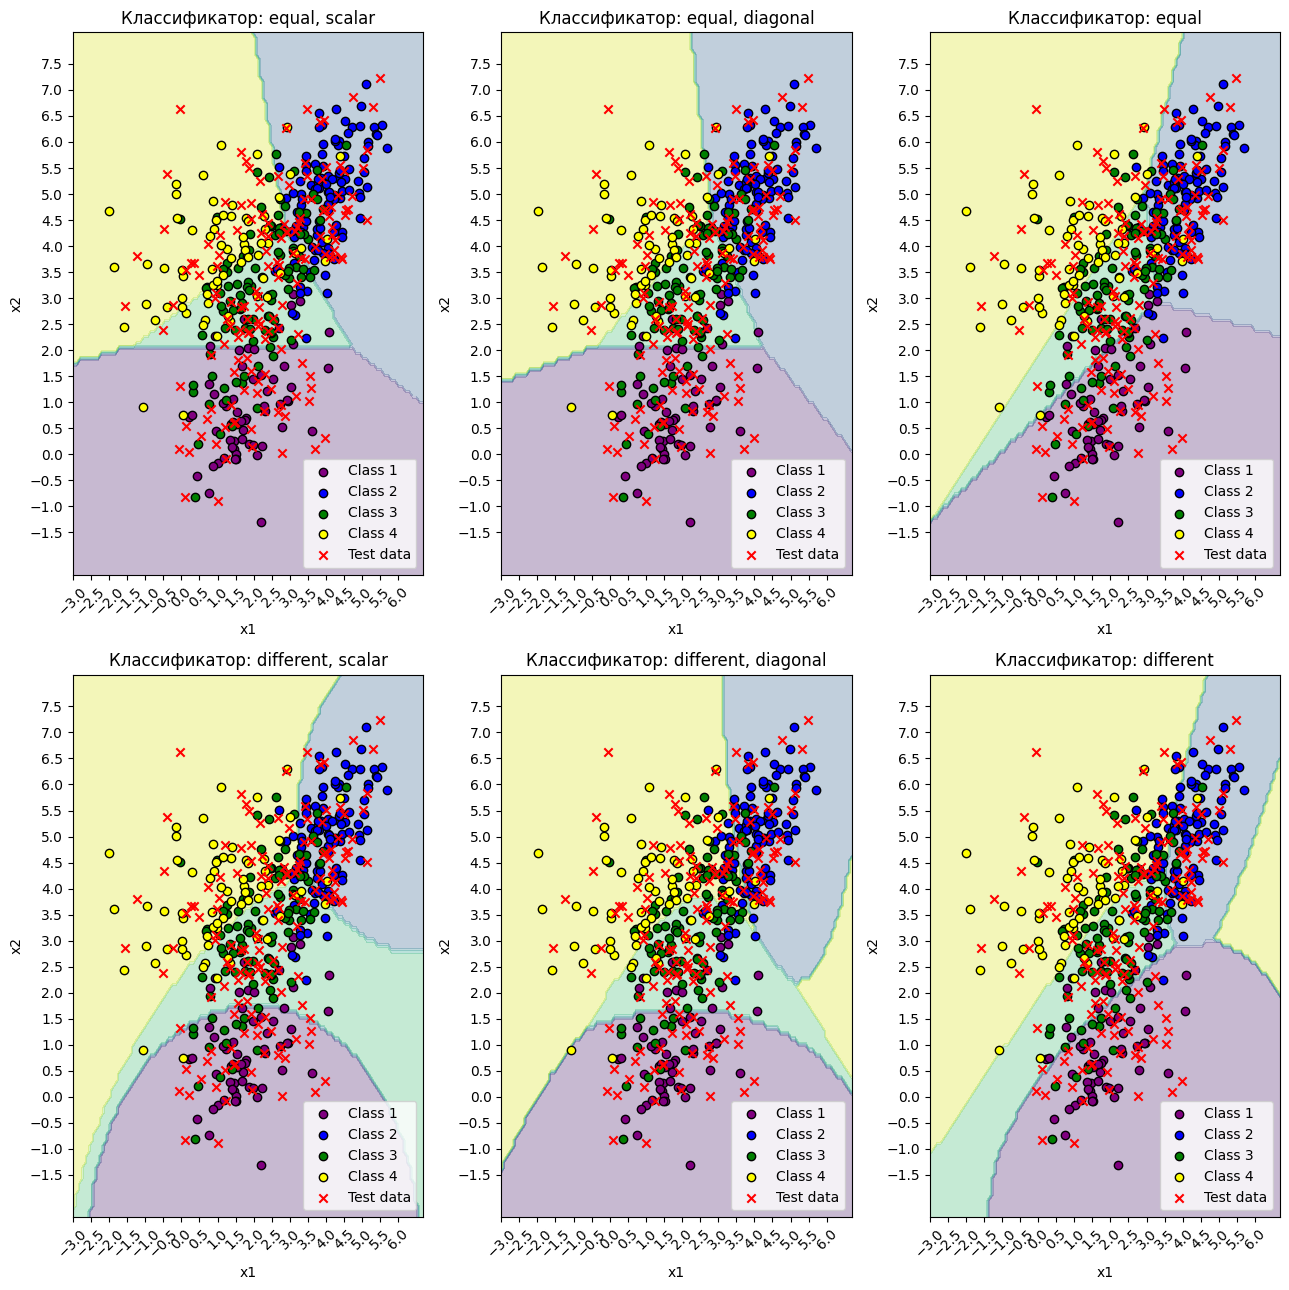

In [196]:
# Определяем цвета для каждого класса
class_colors = {
    1: 'purple',
    2: 'blue',
    3: 'green',
    4: 'yellow'
}
# Общая визуализация для всех классификаторов
x1_range = np.linspace(X_train['x1'].min() - 1, X_train['x1'].max() + 1, 100)
x2_range = np.linspace(X_train['x2'].min() - 1, X_train['x2'].max() + 1, 100)
xx, yy = np.meshgrid(x1_range, x2_range)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Визуализация
plt.figure(figsize=(13, 13))

num_classifiers = len(classifiers)
rows = (num_classifiers // 3) + (num_classifiers % 3 > 0)  # Определяем количество строк

for idx, (name, clf) in enumerate(classifiers.items()):
    # Получаем предсказания для сетки
    _, grid_predictions = clf.predict_all(
        pd.DataFrame(grid_points, columns=['x1', 'x2']))
    grid_predictions = np.array(grid_predictions)

    # Преобразуем предсказания в форму сетки
    Z = grid_predictions.reshape(xx.shape)

    plt.subplot(rows, 3, idx + 1)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    # Используем заданные цвета для классов
    for cls in classes:
        plt.scatter(X_train[y_train == cls]['x1'], 
                    X_train[y_train == cls]['x2'], 
                    color=class_colors[cls], 
                    edgecolor='k', 
                    marker='o', 
                    label=f'Class {cls}')
    
    plt.scatter(X_test['x1'], X_test['x2'], c='red', 
                edgecolor='k', marker='x', label='Test data')

    plt.title(f'Классификатор: {name}')
    plt.xlabel('x1')
    plt.xticks(np.arange(-3, 6.5, 0.5), rotation=45)
    plt.ylabel('x2')
    plt.yticks(np.arange(-1.5, 8, 0.5))
    plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_48090/1877503075.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  edgecolor='k', marker='o', label='Train data', cmap=plt.cm.get_cmap('viridis', len(class_colors)))
/tmp/ipykernel_48090/1877503075.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test['x1'], X_test['x2'], c='red',


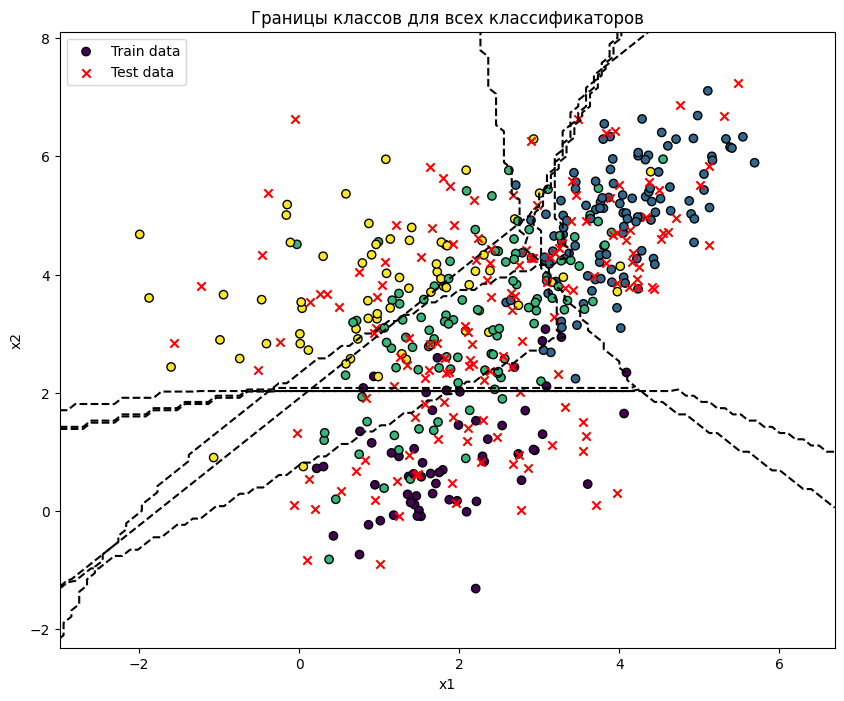

In [197]:

# Общая визуализация для всех классификаторов
plt.figure(figsize=(10, 8))
for idx, (name, clf) in enumerate(classifiers.items()):
    # Получаем предсказания для сетки
    _, grid_predictions= clf.predict_all(
        pd.DataFrame(grid_points, columns=['x1', 'x2']))
    grid_predictions = np.array(grid_predictions)

    # Преобразуем предсказания в форму сетки
    Z = grid_predictions.reshape(xx.shape)

    plt.contour(xx, yy, Z, levels=[0.5 + idx,
                1.5 + idx], colors='k', linestyles='--')

plt.scatter(X_train['x1'], X_train['x2'], c=y_train,
            edgecolor='k', marker='o', label='Train data', cmap=plt.cm.get_cmap('viridis', len(class_colors)))
plt.scatter(X_test['x1'], X_test['x2'], c='red',
            edgecolor='k', marker='x', label='Test data')
plt.title('Границы классов для всех классификаторов')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

### Задание 4
Рассчитать точности (accuracy) построенных классификаторов на обучающей и тестовой выборках, представить данные в графическом виде (bar charts).

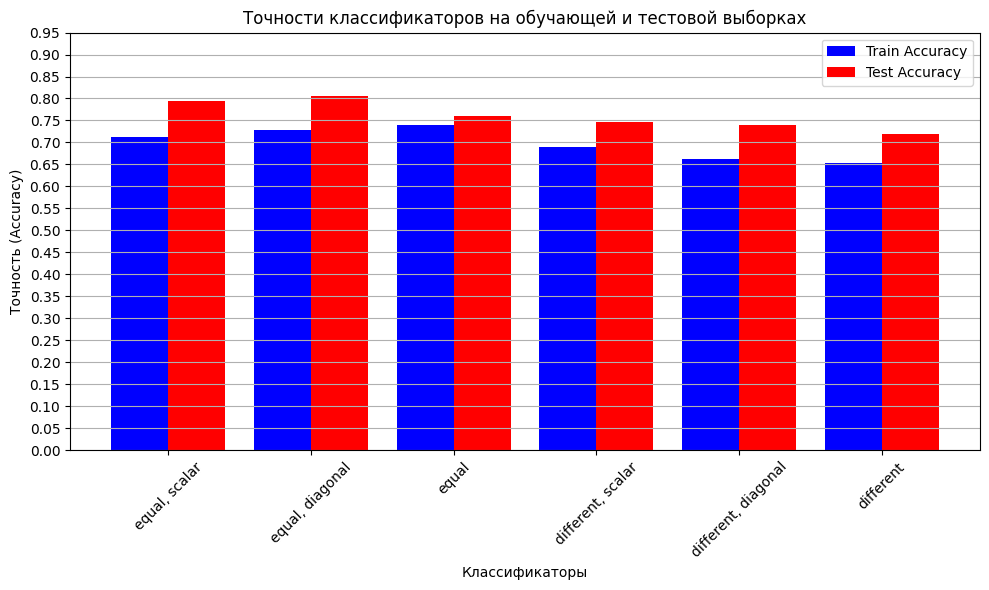

In [198]:
# Словари для хранения точностей
train_accuracies = {}
test_accuracies = {}

# Рассчитываем точности для каждого классификатора
for name, clf in classifiers.items():
    _, train_predictions = clf.predict_all(X_train)
    _, test_predictions = clf.predict_all(X_test)

    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    train_accuracies[name] = train_accuracy
    test_accuracies[name] = test_accuracy

labels = list(train_accuracies.keys())
train_values = list(train_accuracies.values())
test_values = list(test_accuracies.values())

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, train_values, width=0.4,
        label='Train Accuracy', color='b', align='center')
plt.bar([p + 0.4 for p in x], test_values, width=0.4,
        label='Test Accuracy', color='r', align='center')

plt.xlabel('Классификаторы')
plt.ylabel('Точность (Accuracy)')
plt.title('Точности классификаторов на обучающей и тестовой выборках')
plt.yticks(np.arange(0, 1, 0.05))
plt.xticks([p + 0.2 for p in x], labels, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

### Задание 5
Для каждого классификатора построить:
1. micro-averaged ROC-кривые
2. micro-averaged PR-кривые
3. рассчитать micro-averaged ROC AUC и PR AUC
4. macro-averaged ROC-кривые
5. macro-averaged PR-кривые
6. рассчитать macro-averaged ROC AUC и PR AUC

на обучающей и тестовой выборках.

Macro-averaged для обучающей выборки

In [199]:
def plot_macro_roc_pr_curves(classifier, classifier_name, X, y):
    # Бинаризация таргетов
    y_bin = label_binarize(y, classes=classes)
    num_classes = len(classes)
    
    # Получаем предсказания вероятностей для каждого класса
    y_score = np.array(classifier.predict_all(X)[0])  # Убедитесь, что это NumPy массив
    
    # Инициализация графиков
    plt.figure(figsize=(10, 5))
    
    # Общий заголовок с именем классификатора
    plt.suptitle(f'Macro-averaged ROC and PR Curves for {classifier_name}', fontsize=16)
    
    # Macro-averaged ROC-кривая
    plt.subplot(1, 2, 1)
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for cl in classes:
        fpr[cl], tpr[cl], _ = roc_curve(y_bin[:, cl - 1], y_score[:, cl - 1])
        roc_auc[cl] = auc(fpr[cl], tpr[cl])
        plt.plot(fpr[cl], tpr[cl], label=f'Class {cl} (AUC = {roc_auc[cl]:.3f})')

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)
    for cl in classes:
        mean_tpr += np.interp(fpr_grid, fpr[cl], tpr[cl])

    mean_tpr /= num_classes
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"],label=f'Macro-averaged (AUC = {roc_auc["macro"]:.3f})', color='blue', linestyle='--',)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title('Macro-averaged ROC Curve')
    plt.legend(loc='lower right')
    
    # # Macro-averaged PR-кривая
    plt.subplot(1, 2, 2)
    precision, recall, pr_auc = dict(), dict(), dict()
    for cl in classes:
        precision[cl], recall[cl], _ = precision_recall_curve(y_bin[:, cl - 1], y_score[:, cl - 1])
        pr_auc[cl] = auc(recall[cl], precision[cl])
        # plt.plot(recall[cl], precision[cl], label=f'Class {cl} (AUC = {pr_auc[cl]:.3f})')
    
    # Macro-averaged PR
    precision_grid = np.linspace(0.0, 1.0, 1000)
    mean_precision = np.zeros_like(precision_grid)
    for cl in classes:
        mean_precision += np.interp(precision_grid, precision[cl], recall[cl])

    mean_precision /= num_classes
    precision["macro"] = precision_grid
    recall["macro"] = mean_precision
    pr_auc["macro"] = auc(recall["macro"], precision["macro"])
    plt.plot(recall["macro"], precision["macro"], color='blue', linestyle='--', label=f'Macro-averaged (AUC = {pr_auc["macro"]:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title('Macro-averaged Precision-Recall Curve')
    plt.legend(loc='lower left')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Убедитесь, что заголовок не перекрывается
    plt.show()

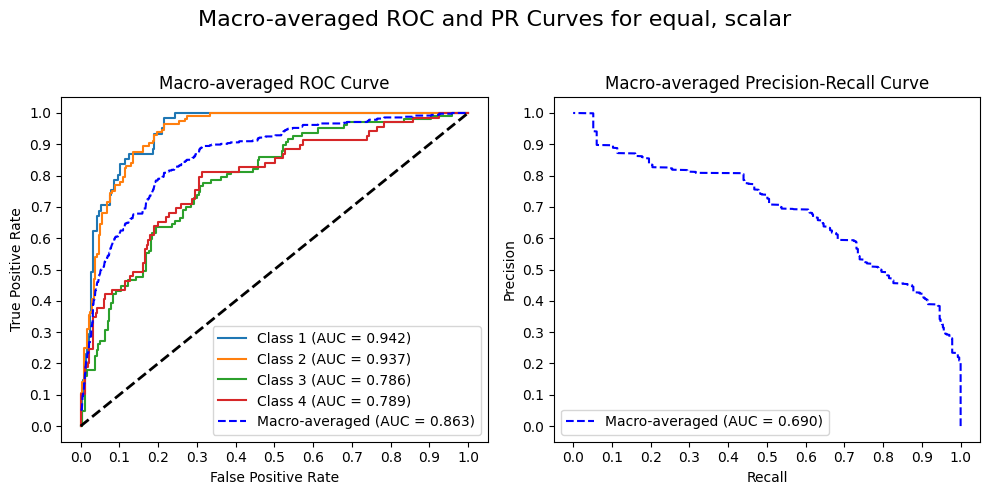

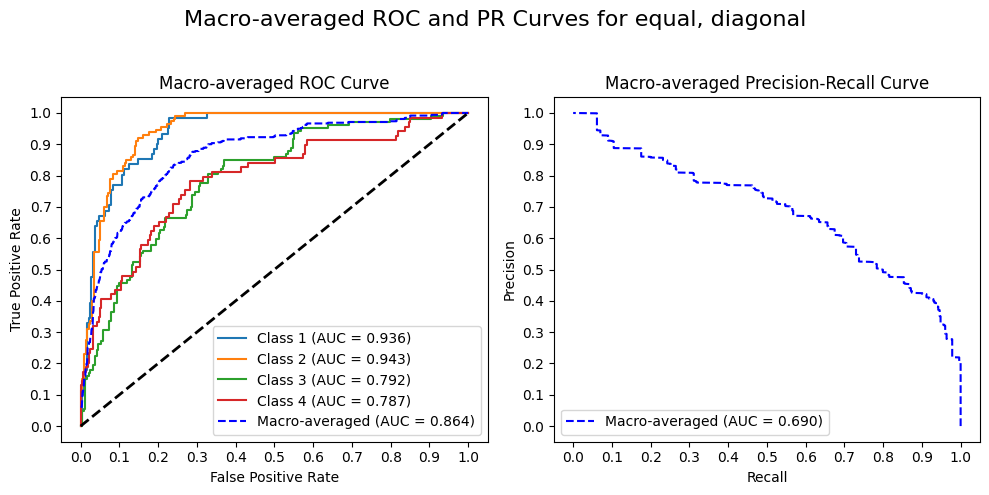

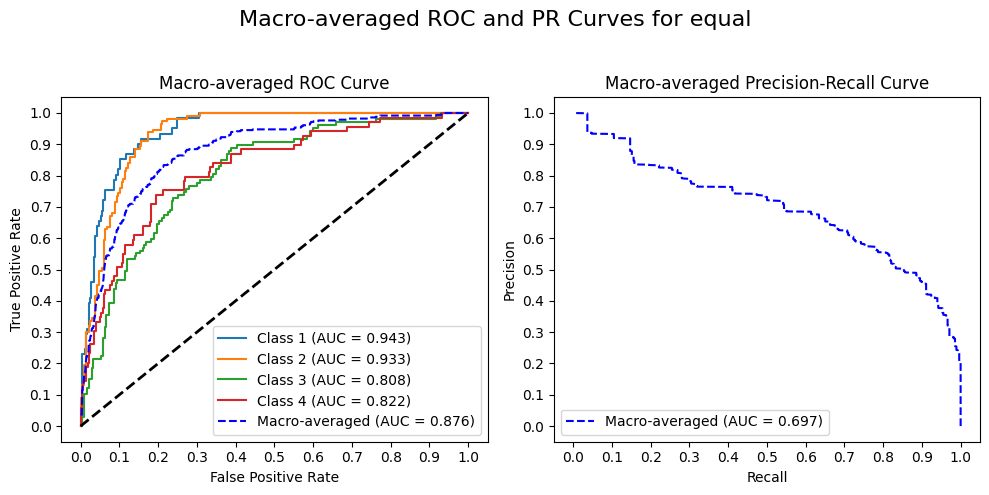

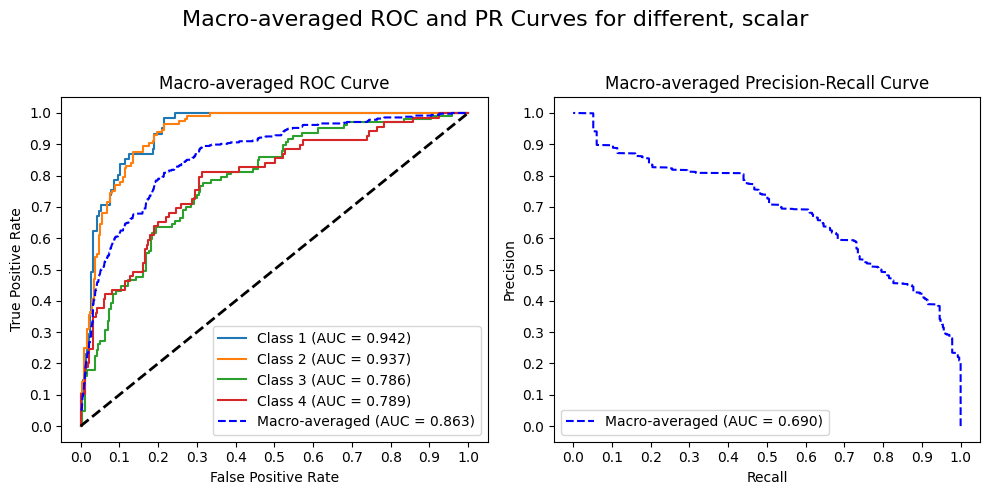

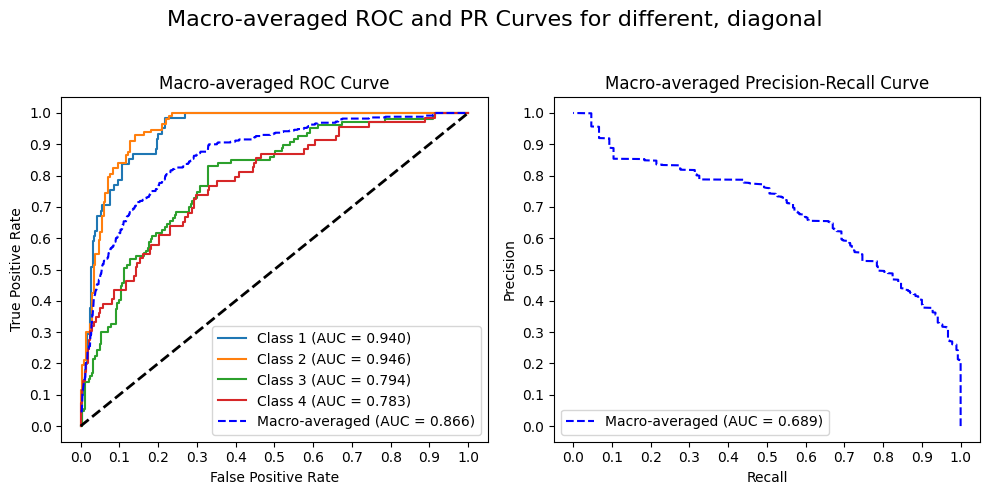

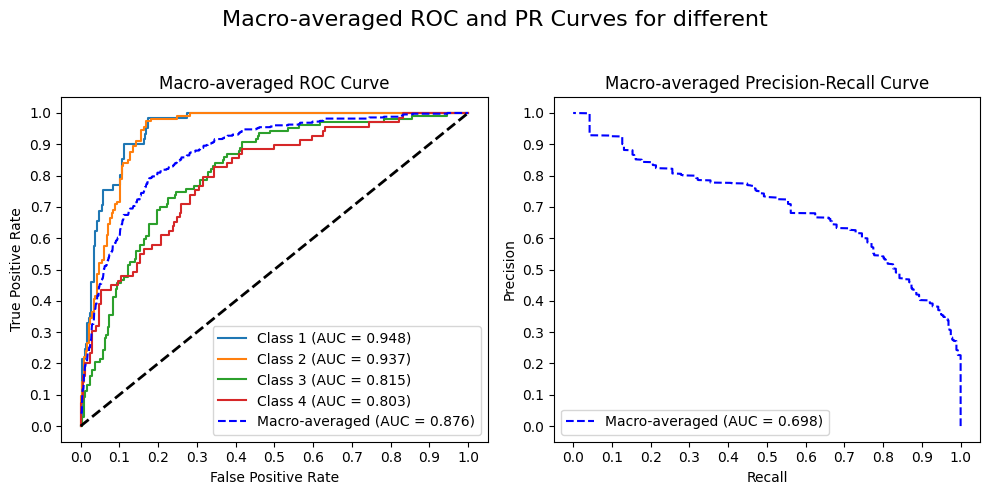

In [200]:
for name, classifier in classifiers.items():
    plot_macro_roc_pr_curves(classifier, name,X_train, y_train)

Macro-averaged для тестовой выборки

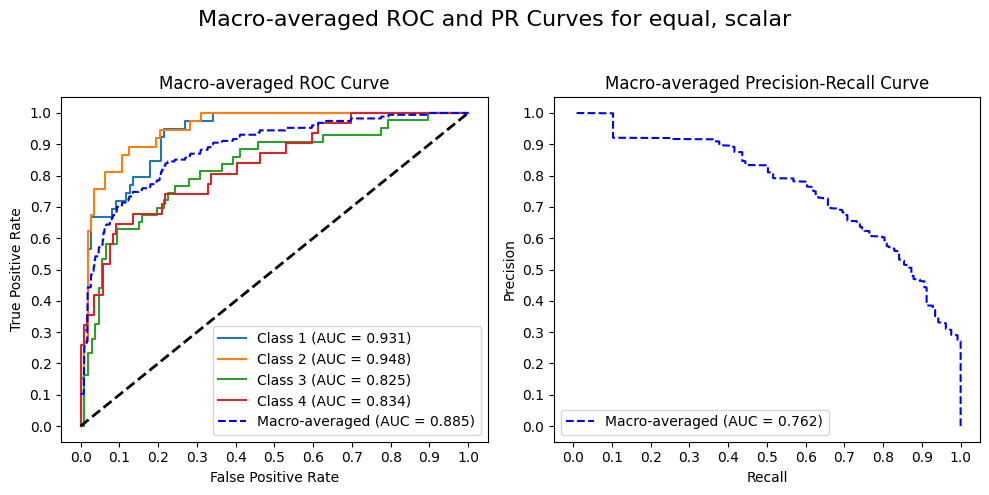

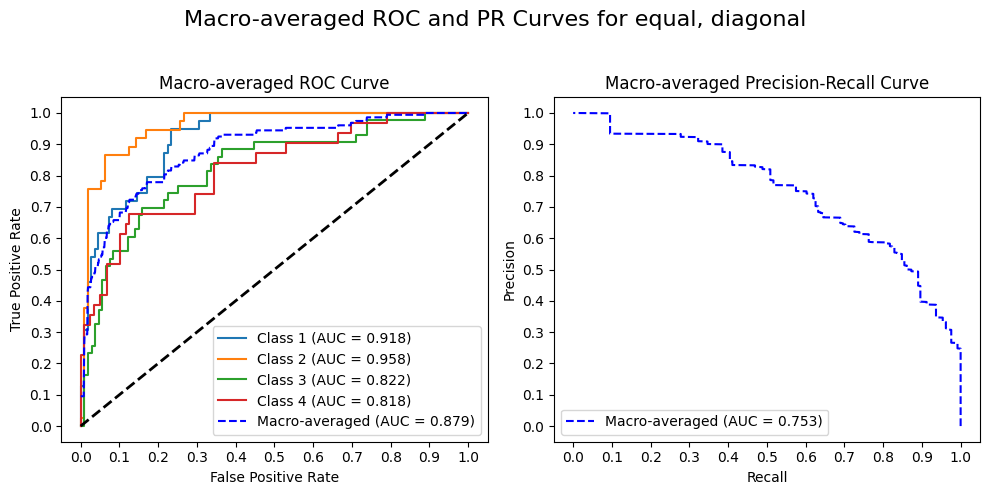

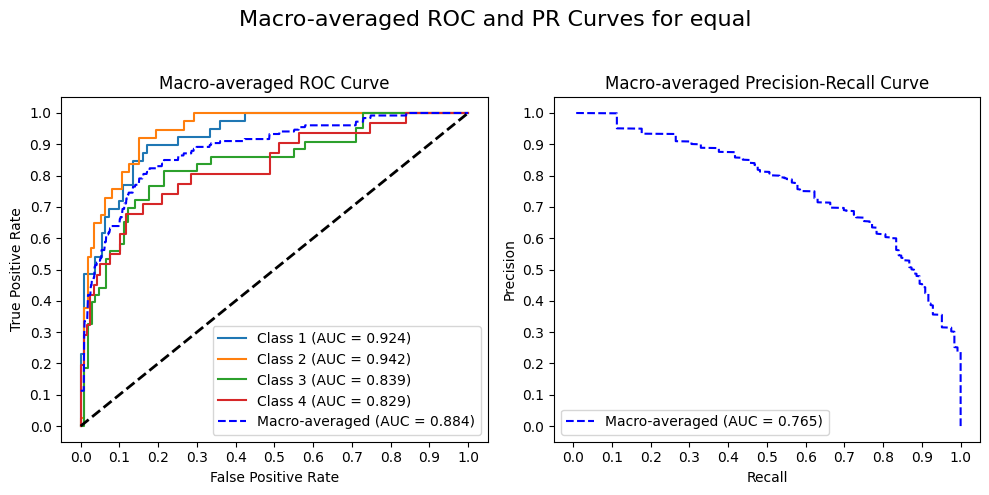

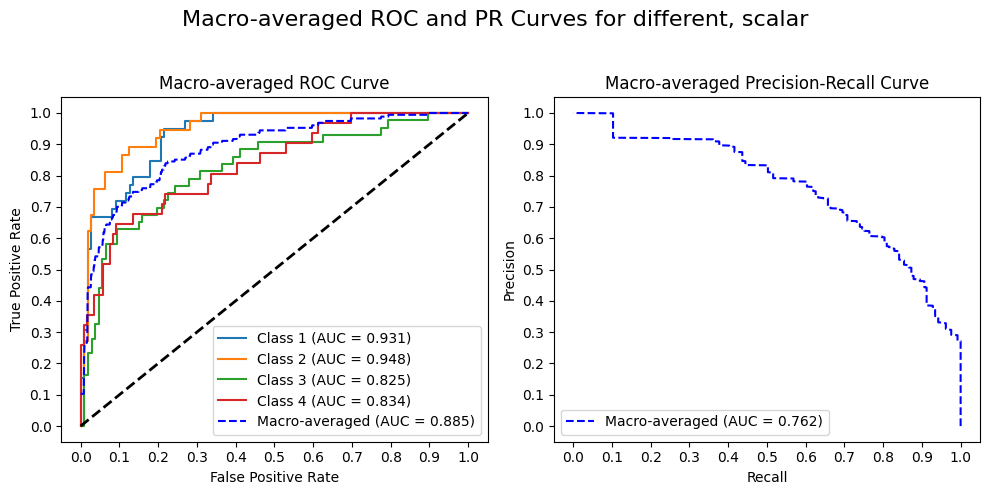

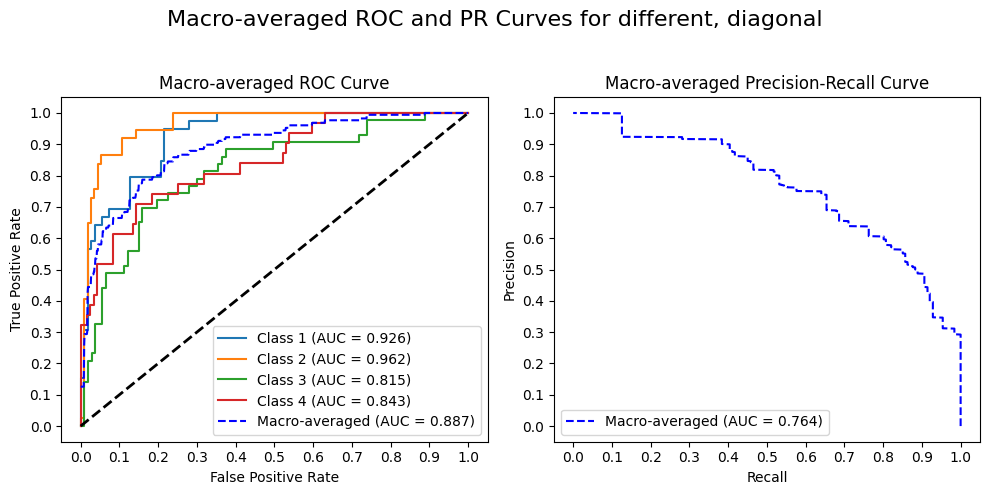

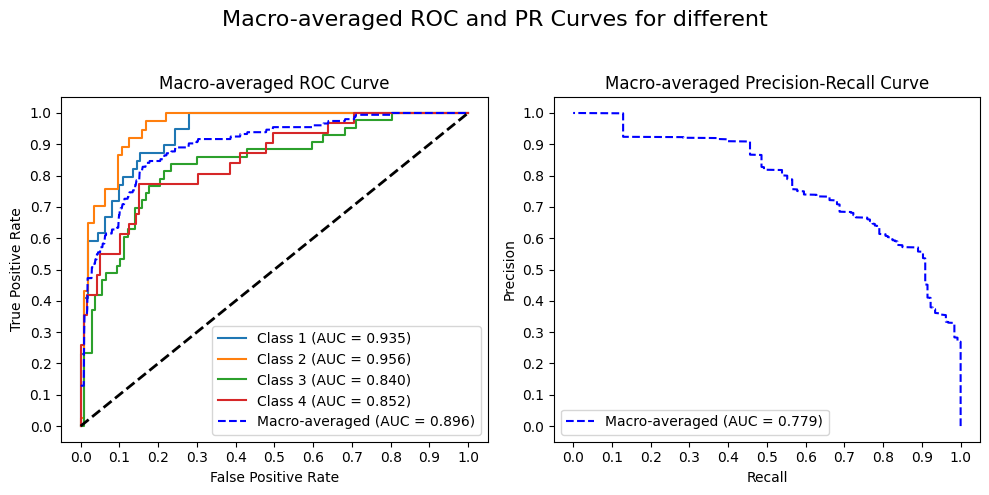

In [201]:
for name, classifier in classifiers.items():
    plot_macro_roc_pr_curves(classifier,name, X_test, y_test)

Micro-averaged для обучающей выборки

In [202]:
def plot_micro_roc_pr_curves(classifier, classifier_name, X, y):
    # Бинаризация таргетов
    y_bin = label_binarize(y, classes=classes)
    
    # Получаем предсказания вероятностей для каждого класса
    y_score = np.array(classifier.predict_all(X)[0])  # Убедитесь, что это NumPy массив
    
    # Инициализация графиков
    plt.figure(figsize=(10, 5))
    
    # Общий заголовок с именем классификатора
    plt.suptitle(f'Micro-averaged ROC and PR Curves for {classifier_name}', fontsize=16)
    
    # Micro-averaged ROC-кривая
    plt.subplot(1, 2, 1)
    fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color='blue', label=f'Micro-averaged (AUC = {roc_auc_micro:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title('Micro-averaged ROC Curve')
    plt.legend(loc='lower right')
    
    # Micro-averaged PR-кривая
    plt.subplot(1, 2, 2)
    precision_micro, recall_micro, _ = precision_recall_curve(y_bin.ravel(), y_score.ravel())
    pr_auc_micro = auc(recall_micro, precision_micro)
    plt.plot(recall_micro, precision_micro, color='blue', label=f'Micro-averaged (AUC = {pr_auc_micro:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.01, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.title('Micro-averaged Precision-Recall Curve')
    plt.legend(loc='lower left')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Убедитесь, что заголовок не перекрывается
    plt.show()

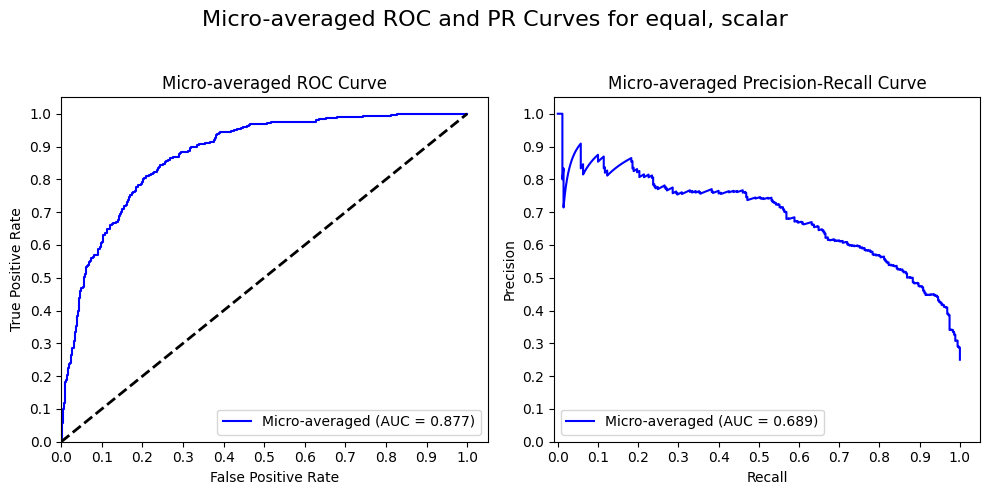

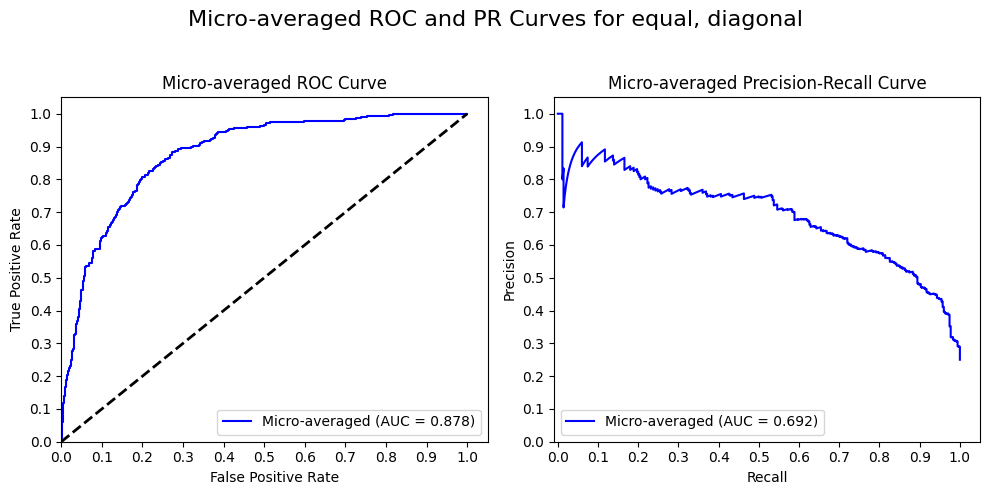

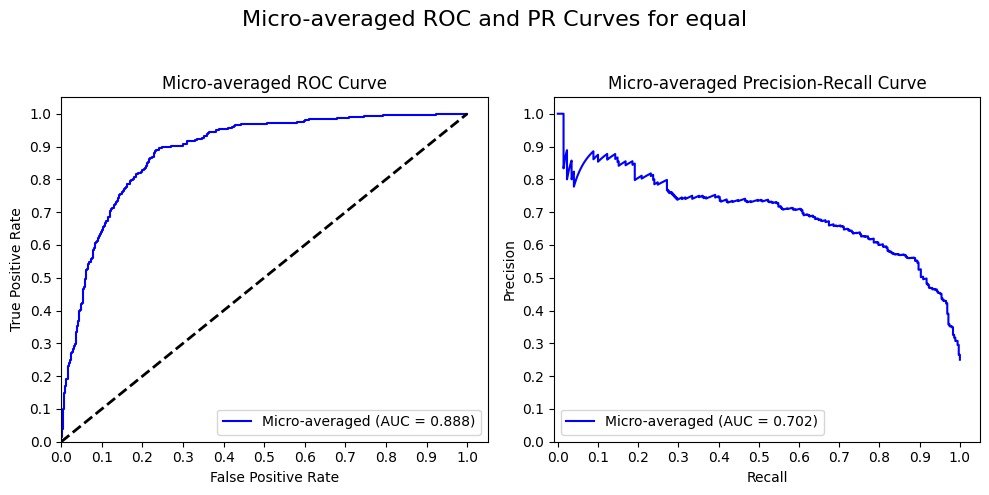

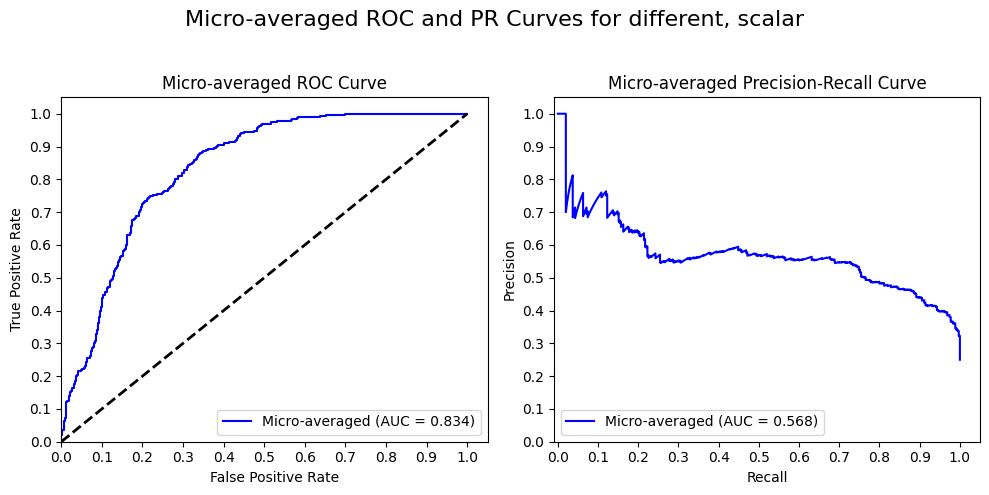

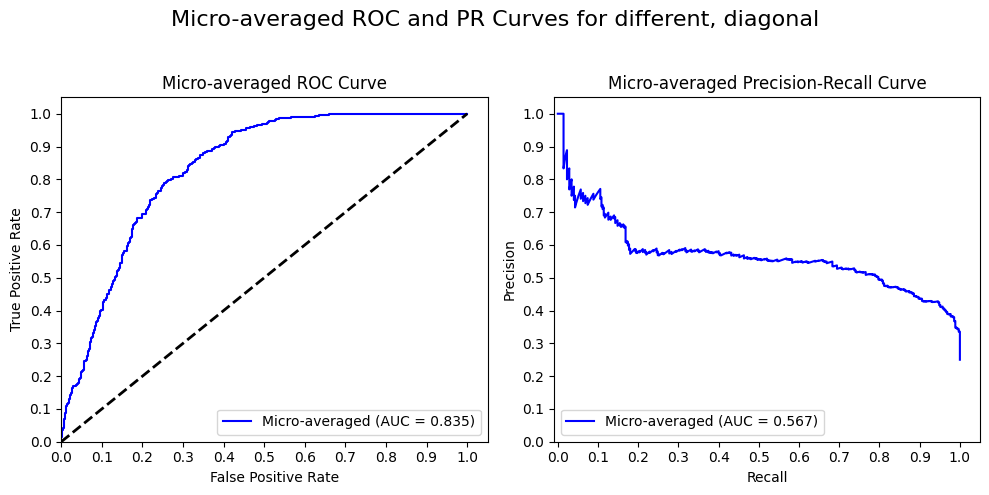

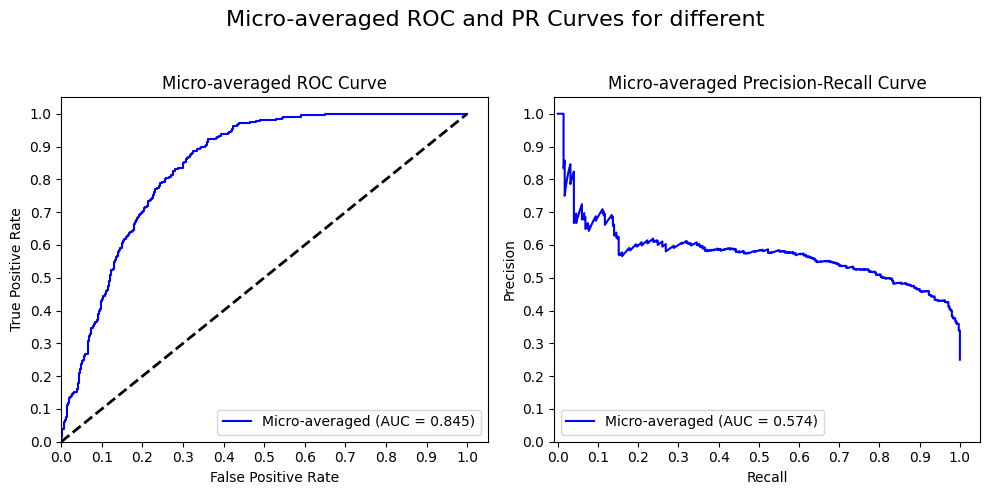

In [203]:
for name, classifier in classifiers.items():
    plot_micro_roc_pr_curves(classifier, name, X_train, y_train)

Micro-averaged для тестовой выборки

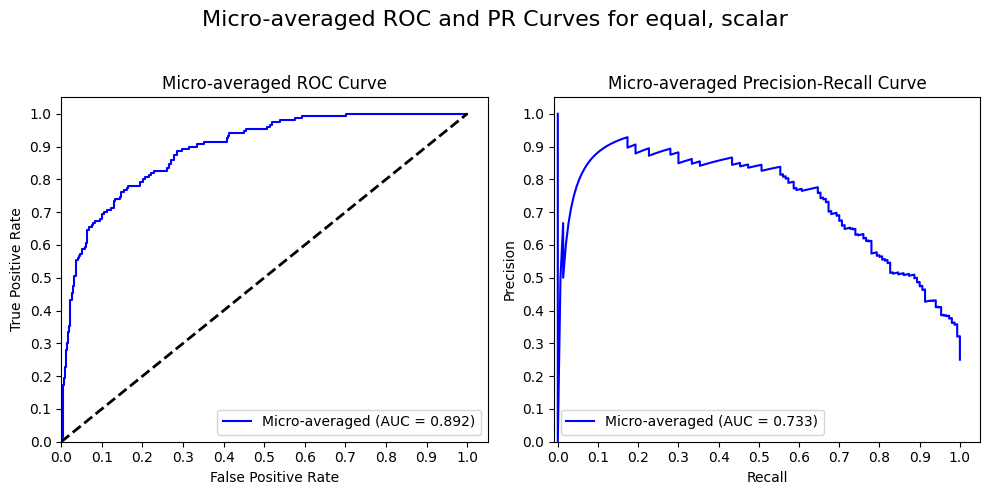

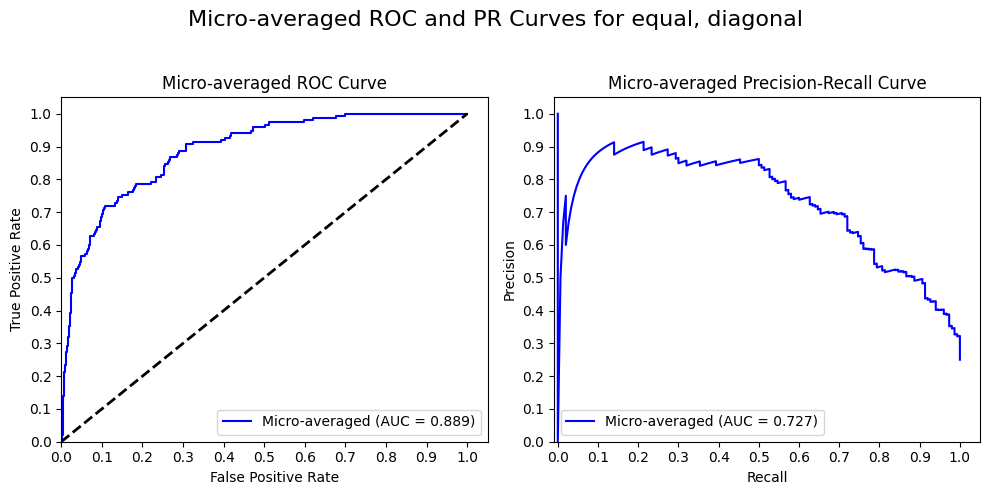

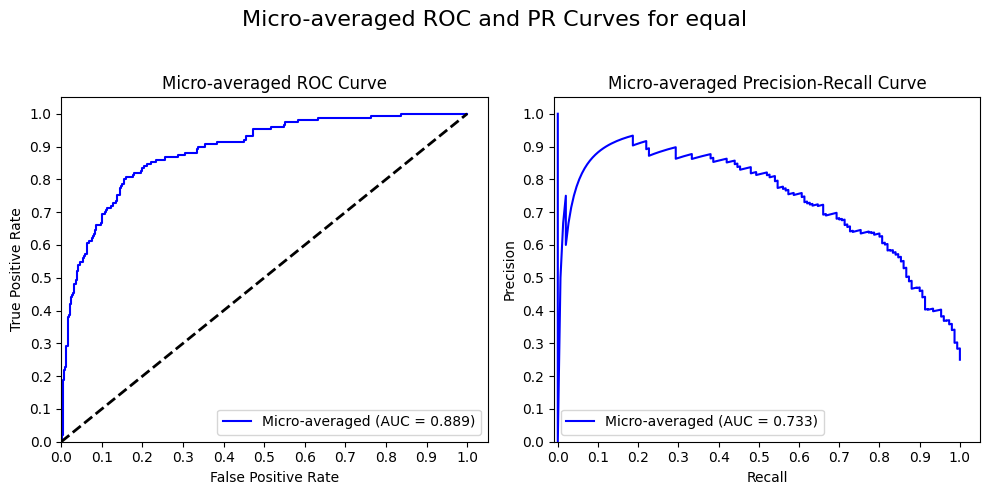

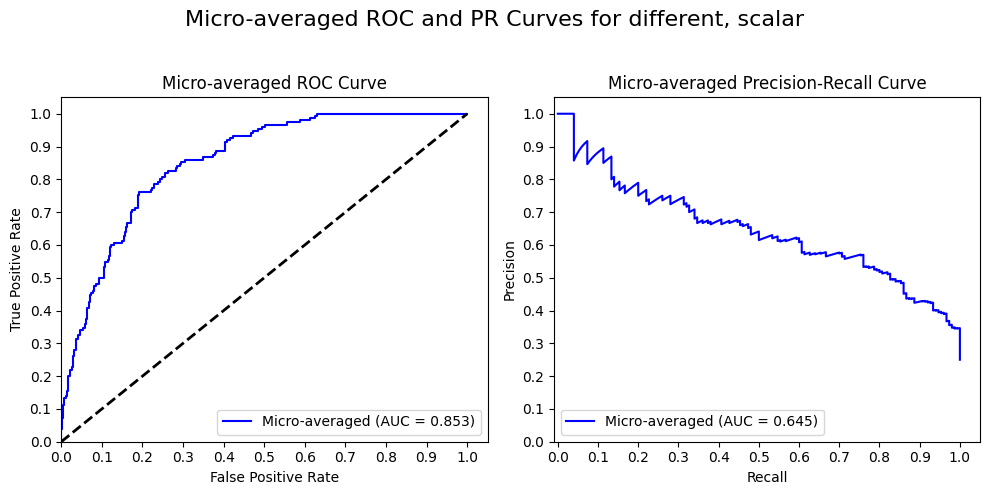

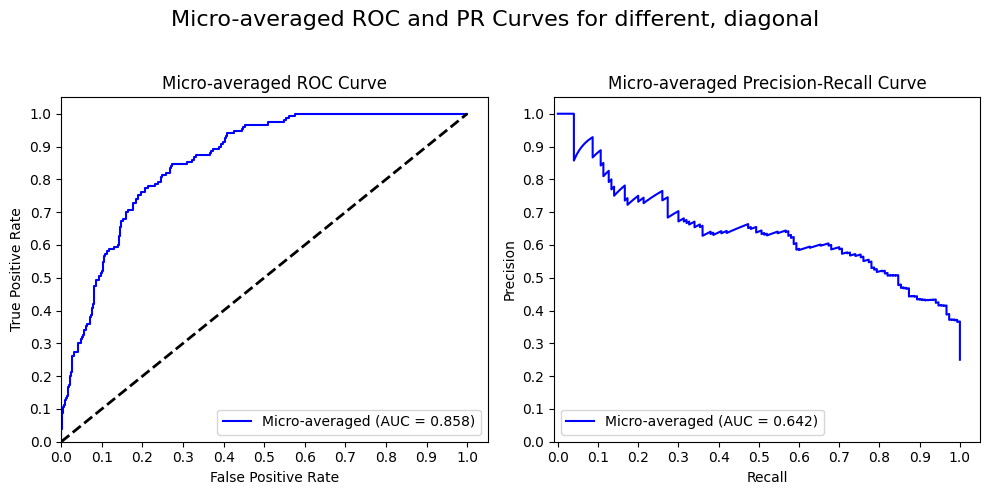

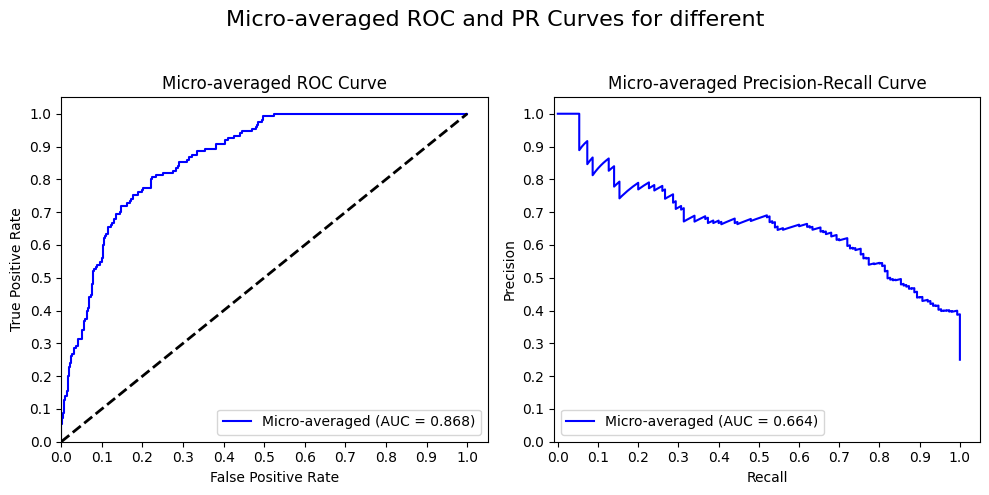

In [204]:
for name, classifier in classifiers.items():
    plot_micro_roc_pr_curves(classifier, name, X_test, y_test)

### Задание 6
Сделать выводы о влиянии предположений о модели обучающих данных на точность байесовской классификации.